# DATA 620 Final Project
#### Amazon Software Reviews

Benson Toi, Noah Collin, Ahmed Elsaeyed

#### Data source:
https://nijianmo.github.io/amazon/index.html

This is a text analyisis of Amazon reviews of software from 1998-2015

### Dependencies

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import random
import nltk
#nltk.download('punkt')
from tqdm import tqdm, trange #for progress bars of computation in Jupyter, see https://www.youtube.com/watch?v=n4E7of9BINo
#import pytorch

In [2]:
from transformers import pipeline

C:\Users\Noah\.conda\envs\NLTK etal\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("Pandas version: {}".format(pd.__version__))
#print("datetime version: {}".format(datetime.__version__))
print("Seaborn version: {}".format(sns.__version__))

Pandas version: 1.4.2
Seaborn version: 0.11.2


### Data

In [4]:
df = pd.read_json('Software.json',  lines=True) #lines equal true because the CSV has \n chars
#again, data from here: 
# https://nijianmo.github.io/amazon/index.html

### Data Exploration

In [5]:
df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image'],
      dtype='object')

In [6]:
initialCols = ['overall', 'verified', 'reviewTime', 'reviewerID', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime',]

In [7]:
df = df[initialCols]

In [8]:
df.head(3)

,overall,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime
0,4,True,"03 11, 2014",A240ORQ2LF9LUI,{'Format:': ' Loose Leaf'},Michelle W,The materials arrived early and were in excell...,Material Great,1394496000
1,4,True,"02 23, 2014",A1YCCU0YRLS0FE,{'Format:': ' Loose Leaf'},Rosalind White Ames,I am really enjoying this book with the worksh...,Health,1393113600
2,1,True,"02 17, 2014",A1BJHRQDYVAY2J,{'Format:': ' Loose Leaf'},Allan R. Baker,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",ARE YOU KIDING ME?,1392595200


In [9]:
df['reviewerID'].describe()

count            459436
unique           375147
top       A5JLAU2ARJ0BO
freq                 73
Name: reviewerID, dtype: object

A5JLAU2ARJ0BO gave 73 reviews.  We might do some analysis on this reviewer alone.

In [10]:
def HumanTime (x):
    return datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')

print(HumanTime(df['unixReviewTime'][40000]) )

def TimeOfDay(x):
    humanTime = HumanTime(x)
    return re.findall("\d{2}:\d{2}:\d{2}", humanTime)[0]
print(TimeOfDay(df['unixReviewTime'][40000]) )

2009-06-24 00:00:00
00:00:00


<i> Unfortunately, the times of day seem to mostly be absent from the data.  That could have made for interesting analysis. </i>

In [11]:
df['ReviewTime']= tqdm(df.unixReviewTime.apply(HumanTime))


100%|██████████| 459436/459436 [00:00<00:00, 4688120.08it/s]


In [12]:
df['ReviewTime'].head(3)

0    2014-03-11 00:00:00
1    2014-02-23 00:00:00
2    2014-02-17 00:00:00
Name: ReviewTime, dtype: object

In [13]:
df['Year'] = df['ReviewTime'].apply(lambda x: int(re.findall ("\d+", x)[0]))

In [14]:
#df['Year'].value_counts().sort_index()

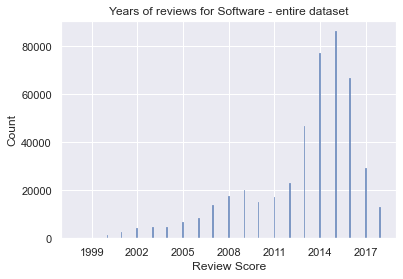

In [15]:
sns.set(style="darkgrid")
sns.histplot(df['Year']).set(title = "Years of reviews for Software - entire dataset",
                                        xlabel = 'Review Score'
                            )
plt.xticks([i for i in range(1999,2018,3)])
plt.show()

In [16]:
df.reviewText.describe()

count     459370
unique    421432
top         good
freq         811
Name: reviewText, dtype: object

In [17]:
df.summary.describe()

count         459380
unique        286888
top       Five Stars
freq           51188
Name: summary, dtype: object

In [18]:
df.overall.value_counts().sort_index()

1    102548
2     31445
3     39395
4     73596
5    212452
Name: overall, dtype: int64

In [19]:
df.overall.describe() #Review Scores

count    459436.000000
mean          3.570175
std           1.626662
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [20]:
df['overall'].median()

4.0

In [21]:
df['style'].describe()

count                            234401
unique                              423
top       {'Platform:': ' PC Download'}
freq                              50647
Name: style, dtype: object

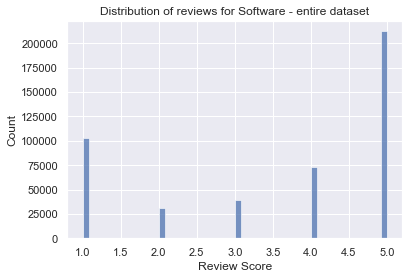

In [22]:
sns.set(style="darkgrid")
sns.histplot(df['overall']).set(title = "Distribution of reviews for Software - entire dataset",
                                        xlabel = 'Review Score')
plt.show()

Mostly five-star reviews.

In [23]:
oneStarReviews = df[df['overall']==1]
oneStarReviews.shape

(102548, 11)

In [24]:
twoStarReviews = df[df['overall']==2]
threeStarReviews = df[df['overall']==3]
fourStarReviews = df[df['overall']==4]
fiveStarReviews = df[df['overall']==5]

### Step 1: Make a dataframe with 1000 random rows to perform analysis

It's not feasible / useful to run the analysis on the entire dataset for this project.  So for the rest of the notebook, it'll just be 1000 random rows:

In [25]:
random.seed(6174)
#Kaprekar’s constant

In [26]:
randomSelection = random.choices(range(len(df)), k=1000) 
# we're going to work with 1000 reviews to lessen run times
#randomSelection

In [27]:
df1000ReadIn = False
try:
    df1000 = pd.read_csv("df1000.csv")
    df1000ReadIn = True
except:

    df1000 = df.loc[randomSelection,]
df1000.head(3)

,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,ReviewTime,Year,zero shot facebook/bart-large-mnli,endorsement per zero shot facebook/bart-large-mnli,disapproval per zero shot facebook/bart-large-mnli,NER dslim bert-base,Num of Recognized Entites dslim bert-base
0,319057,1,False,"11 19, 2016",A2WULF7HX5QRW6,B01019T6O0,{'Style:': ' USB Flash Drive'},fazil,Windows 10 updates all the time! Causing my co...,Garbage!,1479513600,NaN,NaN,2016-11-19 00:00:00,2016,{'sequence': 'Windows 10 updates all the time!...,0.199932,0.800068,"[{'entity': 'B-MISC', 'score': 0.9983368, 'ind...",2
1,351090,5,True,"12 30, 2015",A2LDZGQKQTBLKE,B01637REAM,{'Platform:': ' PC Download'},joe d,I have been using turbo tax from the start way...,Still The Best,1451433600,NaN,NaN,2015-12-30 00:00:00,2015,{'sequence': 'I have been using turbo tax from...,0.847972,0.152028,"[{'entity': 'B-ORG', 'score': 0.9976609, 'inde...",3
2,391520,1,False,"06 29, 2007",AOWZQAE1TO0IA,B000AMPJPY,NaN,Science Minded,Very Buggy software that needs some rewriting....,Don't expect any help,1183075200,NaN,NaN,2007-06-29 00:00:00,2007,{'sequence': 'Very Buggy software that needs s...,0.287219,0.712781,"[{'entity': 'B-MISC', 'score': 0.63482374, 'in...",1


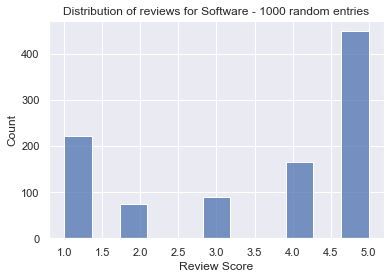

In [28]:
sns.set(style="darkgrid")
sns.histplot(df1000['overall']).set(
    title = "Distribution of reviews for Software - 1000 random entries",
    xlabel = 'Review Score')
plt.show()

This histogram of 1000 random rows resembles the one for the entire dataset

In [29]:
print("""The average score in the dataset was {} whereas 
the mean score for the 1000 random rows was {}.""".format(
round(df['overall'].mean(), 2),
round(df1000['overall'].mean(), 2)
     ))

The average score in the dataset was 3.57 whereas 
the mean score for the 1000 random rows was 3.55.


##### More rigourous comparisons of the dataset to the 1000 random samples could be done, but I'd say this 1000 random rows is representaive enough of the dataset for our NLP puproses.
---------------

We'll also be making a df25 of the first 25 rows for troubleshooting, testing, and the reapply it all to the df1000 later.

In [30]:
df25 = df.loc[randomSelection[:25]]
df25.head(2)

,overall,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,ReviewTime,Year
319057,1,False,"11 19, 2016",A2WULF7HX5QRW6,{'Style:': ' USB Flash Drive'},fazil,Windows 10 updates all the time! Causing my co...,Garbage!,1479513600,2016-11-19 00:00:00,2016
351090,5,True,"12 30, 2015",A2LDZGQKQTBLKE,{'Platform:': ' PC Download'},joe d,I have been using turbo tax from the start way...,Still The Best,1451433600,2015-12-30 00:00:00,2015


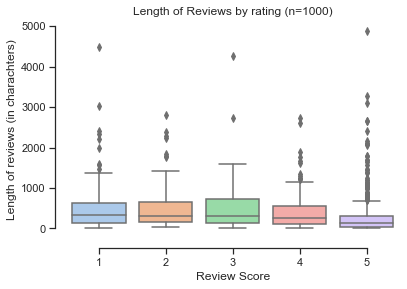

In [77]:
temp = [len(i) for i in df1000['reviewText']]

sns.set_theme(style="ticks", palette="pastel")

sns.boxplot(x="overall", y=temp,
            data=df1000).\
set(title = "Length of Reviews by rating (n=1000)",
                                        xlabel = 'Review Score', 
                           ylabel = 'Length of reviews (in charachters)')
sns.despine(offset=10, trim=True)

del temp

##### There doesn't seem to be clear or strong relationship between the length of a review and the rating.  It does seem that 5-star reviews seem to be a bit shorter.  

##### Defining the voabulary of the reviews:

In [32]:
vocab= []
for c, r in df1000.iterrows():
    tokens =( nltk.word_tokenize(r['reviewText']) )
    for token in tokens:
        vocab.append(token)

In [33]:
vocabulary = set(vocab) # to assure no duplicates.  As of now, we haven't handled capitalization

## <p>Hugging Face</p>

https://huggingface.co/

The following cells will perform text analysis using models from the Hugging Face model hub 

### Sentiment Analysis
https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english

In [34]:
classifier = pipeline("sentiment-analysis")
currentClassifierType = "sentiment-analysis" #This variable will be updated throughtout the notebook
#It assures that the correct classifier is in user
#Run the notebook in order to assure proper classifier


#This cell will download models the first time it's run.  
#These are large so don't use a metered connection if possible.
#default model used, link here:
#https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [35]:
def performDefaultSetntimentAnalysis(x):
    if(currentClassifierType != "sentiment-analysis"):
        print("You're using the wrong classifier!  Run the notebook in order.")
        return None
    try:
        return classifier(x)
    except:
        return"UNKNOWN"

In [36]:

df25['distilbert-base-uncased sentiment-analysis'] = tqdm(
    df25['reviewText'].apply(performDefaultSetntimentAnalysis)
,total = len(df25))
#This cell will take several minutes to run

100%|██████████| 25/25 [00:00<00:00, 25001.81it/s]


In [37]:
df25.head(3)

,overall,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,ReviewTime,Year,distilbert-base-uncased sentiment-analysis
319057,1,False,"11 19, 2016",A2WULF7HX5QRW6,{'Style:': ' USB Flash Drive'},fazil,Windows 10 updates all the time! Causing my co...,Garbage!,1479513600,2016-11-19 00:00:00,2016,"[{'label': 'NEGATIVE', 'score': 0.999703466892..."
351090,5,True,"12 30, 2015",A2LDZGQKQTBLKE,{'Platform:': ' PC Download'},joe d,I have been using turbo tax from the start way...,Still The Best,1451433600,2015-12-30 00:00:00,2015,"[{'label': 'NEGATIVE', 'score': 0.993547618389..."
391520,1,False,"06 29, 2007",AOWZQAE1TO0IA,NaN,Science Minded,Very Buggy software that needs some rewriting....,Don't expect any help,1183075200,2007-06-29 00:00:00,2007,"[{'label': 'NEGATIVE', 'score': 0.999778926372..."


In [38]:
#df25.iloc[0:14,-1]

In [39]:
negatives = []
positives =[]

for c,r in df25.iterrows():
    #print(r['distilbert-base-uncased sentiment-analysis'][0])
    if(r['distilbert-base-uncased sentiment-analysis'][0]['label']== 'NEGATIVE'):
        negatives.append(r['distilbert-base-uncased sentiment-analysis'][0]['score'])
        positives.append(0)
    else:
        negatives.append(0)
        positives.append(r['distilbert-base-uncased sentiment-analysis'][0]['score'])

In [40]:
'reviewText' in df25

True

In [41]:
positives[:5]
#works as expected

[0, 0, 0, 0.9711596369743347, 0]

In [42]:
df25['positive sentiment-analysis'] = positives
df25['negative sentiment-analysis'] = negatives

In [43]:
if( (not(df1000ReadIn)) | ('distilbert-base-uncased sentiment-analysis' not in df1000) ):
    df1000['distilbert-base-uncased sentiment-analysis'] = tqdm(
    df1000['reviewText'].apply(performDefaultSetntimentAnalysis)
,total = len(df25))
    
    negatives = []
    positives =[]

    for c,r in df1000.iterrows():
        #print(r['distilbert-base-uncased sentiment-analysis'][0])
        if(r['distilbert-base-uncased sentiment-analysis'] != "UNKNOWN"):
            if(r['distilbert-base-uncased sentiment-analysis'][0]['label']== 'NEGATIVE'):
                negatives.append(r['distilbert-base-uncased sentiment-analysis'][0]['score'])
                positives.append(0)
            elif(r['distilbert-base-uncased sentiment-analysis'][0]['label']== 'POSITIVE'):
                negatives.append(0)
                positives.append(r['distilbert-base-uncased sentiment-analysis'][0]['score'])
        else: #in this case, Sentiment Analysis couldn't be performed
            positives.append(0)
            negatives.append(0)
            
            
    df1000['positive sentiment-analysis'] = positives
    df1000['negative sentiment-analysis'] = negatives
else:
    print('Skipping this cell, df1000 with sentiment analysis read in earlier.')

Token indices sequence length is longer than the specified maximum sequence length for this model (716 > 512). Running this sequence through the model will result in indexing errors
1000it [00:00, 999834.09it/s]         


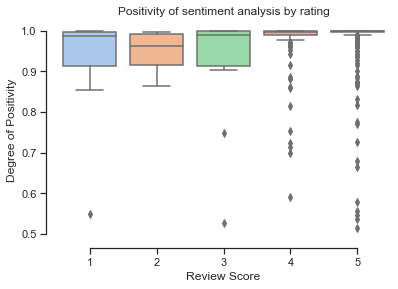

In [44]:
sns.boxplot(x="overall", y="positive sentiment-analysis",
            data=df1000[df1000['positive sentiment-analysis']>0])\
.set(title = "Positivity of sentiment analysis by rating",
                                        xlabel = 'Review Score', 
                           ylabel = 'Degree of Positivity')
sns.despine(offset=10, trim=True)

plt.show()


#### The above graph shows that the positivite sentiment is more concentrated around a score of 5 stars, meaning very positive, in sentiment analysis for 5-star reviews.  But the lower-star reviews have a more of a spread and a lower median positivity.

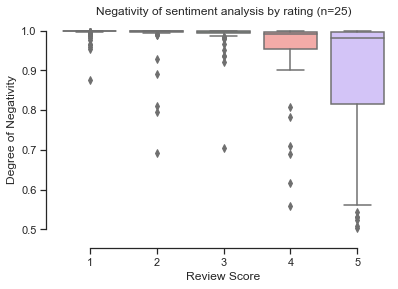

In [45]:
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x="overall", y="negative sentiment-analysis",
            data=df1000[df1000['negative sentiment-analysis']>0])\
.set(title = "Negativity of sentiment analysis by rating (n=25)",
                                        xlabel = 'Review Score', 
                           ylabel = 'Degree of Negativity')
sns.despine(offset=10, trim=True)
plt.show()

 This graph conveys the inverse infromation of the one directly above it.  It shows that the <b>negativity</b> is more concentrated around a score of 1 star.  The Higher-star reviews have a more of a spread and a lower median negativity.

## Zero-Shot classification
https://huggingface.co/facebook/bart-large-mnli

In [46]:
classifier = pipeline("zero-shot-classification")
currentClassifierType = "zero-shot-classification"
type(classifier)
#This cell involves a 1.5+ GB download

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


transformers.pipelines.zero_shot_classification.ZeroShotClassificationPipeline

In [47]:
def performZeroShotAnalysis(x, labs = ['endorsement','disapproval']):
    if (currentClassifierType != "zero-shot-classification"):
        print("You aren't using the right classifer now.  Rerun the cell with the ZeroShot.")
        return None
    try:
        return classifier (x, candidate_labels = labs)
    except:
        return "UNKNOWN"

In [48]:
df25['zero shot facebook/bart-large-mnli'] =  tqdm(df25['reviewText'].\
                                                   apply(performZeroShotAnalysis),
                                                  total = len(df25))

100%|██████████| 25/25 [00:00<?, ?it/s]


In [49]:
if( (not(df1000ReadIn)) | ('zero shot facebook/bart-large-mnli' not in df1000) ):
    df1000['zero shot facebook/bart-large-mnli'] =  tqdm(df1000['reviewText'].\
                                                         apply(performZeroShotAnalysis),
                                                    total = len(df1000))
else:
    print("df1000 containing 'zero shot facebook/bart-large-mnli' read in from file.")
    print("skipping this cell...")

df1000 containing 'zero shot facebook/bart-large-mnli' read in from file.
skipping this cell...


In [50]:
df25['zero shot facebook/bart-large-mnli'].values[0:2]
#notice that the labels, "endorsement and dissaproval" change order.  TODO

array([{'sequence': 'Windows 10 updates all the time! Causing my computer to shut down and restart right in the middle of my projects!!! Garbage!', 'labels': ['disapproval', 'endorsement'], 'scores': [0.8000677824020386, 0.1999322772026062]},
       {'sequence': 'I have been using turbo tax from the start way back.  One year I even took  it H&R to see if it was anything different but they were charging $230.00  Guess what I am still using Turbo Tax with no regrets.', 'labels': ['endorsement', 'disapproval'], 'scores': [0.8479723930358887, 0.15202759206295013]}],
      dtype=object)

In [51]:
#This function will always get the Endorsment rating first, then the disapproval rating second.
#The order can sometimes be given in an unexpected way.
#
def getEndorsementThenDissaproval(x): #x is a dataframe
    endorsementScore = 0
    disapprovalScore = 0
    try:
        if(x['labels'][0]=='endorsement'):
            endorsementScore = x['scores'][0]
            disapprovalScore = x['scores'][1]
            return [endorsementScore, disapprovalScore]
        elif (x['labels'][0]=='disapproval'):
            endorsementScore = x['scores'][1] #flip-flopped
            disapprovalScore = x['scores'][0] 
            return [endorsementScore, disapprovalScore]
        else:
            print('something wrong here')
            return [-2,-2]
    except:
        return [-1,-1]

In [52]:
getEndorsementThenDissaproval ( df25['zero shot facebook/bart-large-mnli'].values[21] )

[0.7803976535797119, 0.21960234642028809]

In [53]:
df25['zero shot facebook/bart-large-mnli'].values[21]

{'sequence': 'This game may be old, but it\'s still fun to play. You can choose the character you want to race with from over 10 characters, including SpongeBob, Catdog, Angelica, and, when you win in all three cups, the Mystery Rider. Even when you reveal who the Mystery Rider is, you can keep playing the game and win gold in the medium and hard modes. Once you beat every cup in every difficulty level, you can ride in a bonus round, which, in my opinion, is not that fun. In the bonus round, you\'re not racing against other characters. Instead, you have to collect a bunch of presents under the amount of time given. Besides that, the rest of the game is fun. The best part of this game is that every time you race, whether in a cup or just for fun, different things happen, which are usually funny. For example, some of the worlds have a few "glitch spots," which cause characters to wind up last. One time, Catdog got stuck on the wall of an obstacle, causing them to get 6th place. It looked

In [54]:
endorsementsList = []
disapprovalsList =[]
for i in df25['zero shot facebook/bart-large-mnli'].index:
    endorsementsList.append(
        getEndorsementThenDissaproval(
        df25['zero shot facebook/bart-large-mnli'][i]
                          )[0]
    )
    disapprovalsList.append(
        getEndorsementThenDissaproval(
        df25['zero shot facebook/bart-large-mnli'][i]
                          )[1]
    )

#for i in range(len(df25)):
#    print(df25['zero shot facebook/bart-large-mnli'][i])

In [55]:
df25['endorsement per zero shot facebook/bart-large-mnli']= endorsementsList
df25['disapproval per zero shot facebook/bart-large-mnli']= disapprovalsList

In [56]:
df25.head(3)

,overall,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,ReviewTime,Year,distilbert-base-uncased sentiment-analysis,positive sentiment-analysis,negative sentiment-analysis,zero shot facebook/bart-large-mnli,endorsement per zero shot facebook/bart-large-mnli,disapproval per zero shot facebook/bart-large-mnli
319057,1,False,"11 19, 2016",A2WULF7HX5QRW6,{'Style:': ' USB Flash Drive'},fazil,Windows 10 updates all the time! Causing my co...,Garbage!,1479513600,2016-11-19 00:00:00,2016,"[{'label': 'NEGATIVE', 'score': 0.999703466892...",0.0,0.999703,{'sequence': 'Windows 10 updates all the time!...,0.199932,0.800068
351090,5,True,"12 30, 2015",A2LDZGQKQTBLKE,{'Platform:': ' PC Download'},joe d,I have been using turbo tax from the start way...,Still The Best,1451433600,2015-12-30 00:00:00,2015,"[{'label': 'NEGATIVE', 'score': 0.993547618389...",0.0,0.993548,{'sequence': 'I have been using turbo tax from...,0.847972,0.152028
391520,1,False,"06 29, 2007",AOWZQAE1TO0IA,NaN,Science Minded,Very Buggy software that needs some rewriting....,Don't expect any help,1183075200,2007-06-29 00:00:00,2007,"[{'label': 'NEGATIVE', 'score': 0.999778926372...",0.0,0.999779,{'sequence': 'Very Buggy software that needs s...,0.287219,0.712781


In [57]:
df25['disapproval per zero shot facebook/bart-large-mnli'].mean()

0.5525741583108902

In [58]:
df25['overall'].mean()

2.88

In [59]:
df1000['overall'].mean()

3.546

In [60]:
if(not(df1000ReadIn)):
    endorsementsList = []
    disapprovalsList =[]
    for i in df1000['zero shot facebook/bart-large-mnli'].index:
        endorsementsList.append(
            getEndorsementThenDissaproval(
            df1000['zero shot facebook/bart-large-mnli'][i]
                              )[0]
        )
        disapprovalsList.append(
            getEndorsementThenDissaproval(
            df1000['zero shot facebook/bart-large-mnli'][i]
                              )[1]
        )

    df1000['endorsement per zero shot facebook/bart-large-mnli']= endorsementsList
    df1000['disapproval per zero shot facebook/bart-large-mnli']= disapprovalsList
else:
    print("df1000 read in, skipping this cell...")

df1000 read in, skipping this cell...


In [61]:
df25['reviewText'][:3]

319057    Windows 10 updates all the time! Causing my co...
351090    I have been using turbo tax from the start way...
391520    Very Buggy software that needs some rewriting....
Name: reviewText, dtype: object

In [62]:
df25.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'ReviewTime',
       'Year', 'distilbert-base-uncased sentiment-analysis',
       'positive sentiment-analysis', 'negative sentiment-analysis',
       'zero shot facebook/bart-large-mnli',
       'endorsement per zero shot facebook/bart-large-mnli',
       'disapproval per zero shot facebook/bart-large-mnli'],
      dtype='object')

In [63]:
df25.head(3)

,overall,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,ReviewTime,Year,distilbert-base-uncased sentiment-analysis,positive sentiment-analysis,negative sentiment-analysis,zero shot facebook/bart-large-mnli,endorsement per zero shot facebook/bart-large-mnli,disapproval per zero shot facebook/bart-large-mnli
319057,1,False,"11 19, 2016",A2WULF7HX5QRW6,{'Style:': ' USB Flash Drive'},fazil,Windows 10 updates all the time! Causing my co...,Garbage!,1479513600,2016-11-19 00:00:00,2016,"[{'label': 'NEGATIVE', 'score': 0.999703466892...",0.0,0.999703,{'sequence': 'Windows 10 updates all the time!...,0.199932,0.800068
351090,5,True,"12 30, 2015",A2LDZGQKQTBLKE,{'Platform:': ' PC Download'},joe d,I have been using turbo tax from the start way...,Still The Best,1451433600,2015-12-30 00:00:00,2015,"[{'label': 'NEGATIVE', 'score': 0.993547618389...",0.0,0.993548,{'sequence': 'I have been using turbo tax from...,0.847972,0.152028
391520,1,False,"06 29, 2007",AOWZQAE1TO0IA,NaN,Science Minded,Very Buggy software that needs some rewriting....,Don't expect any help,1183075200,2007-06-29 00:00:00,2007,"[{'label': 'NEGATIVE', 'score': 0.999778926372...",0.0,0.999779,{'sequence': 'Very Buggy software that needs s...,0.287219,0.712781


In [64]:
len(df1000)

1000

In [65]:
df1000[df1000["endorsement per zero shot facebook/bart-large-mnli"]<=0]

,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,...,ReviewTime,Year,zero shot facebook/bart-large-mnli,endorsement per zero shot facebook/bart-large-mnli,disapproval per zero shot facebook/bart-large-mnli,NER dslim bert-base,Num of Recognized Entites dslim bert-base,distilbert-base-uncased sentiment-analysis,positive sentiment-analysis,negative sentiment-analysis
324,100448,2,True,"02 4, 2011",A39PCQXHDWK2KD,B003YJ5DSS,"{'Format:': ' Box', 'Platform:': ' PC Disc'}",rjmat,After having used M$ Money for 8+ years (which...,This is not M$ Money,...,2011-02-04 00:00:00,2011,"{'sequence': ""After having used M$ Money for 8...",-1.0,-1.0,"[{'entity': 'B-MISC', 'score': 0.94828135, 'in...",14,"[{'label': 'NEGATIVE', 'score': 0.999511361122...",0.0,0.999511
804,100448,2,True,"02 4, 2011",A39PCQXHDWK2KD,B003YJ5DSS,"{'Format:': ' Box', 'Platform:': ' PC Disc'}",rjmat,After having used M$ Money for 8+ years (which...,This is not M$ Money,...,2011-02-04 00:00:00,2011,"{'sequence': ""After having used M$ Money for 8...",-1.0,-1.0,"[{'entity': 'B-MISC', 'score': 0.94828135, 'in...",14,"[{'label': 'NEGATIVE', 'score': 0.999511361122...",0.0,0.999511


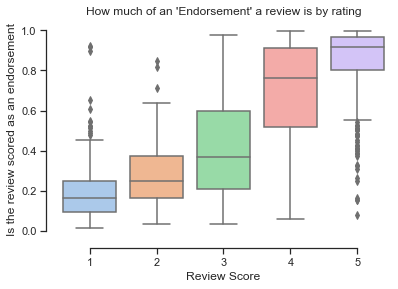

In [66]:
sns.set_theme(style="ticks", palette="pastel")

# Draw a nested boxplot
sns.boxplot(x="overall", y="endorsement per zero shot facebook/bart-large-mnli",
            data=df1000[df1000['endorsement per zero shot facebook/bart-large-mnli']>=0])\
.set(title = "How much of an 'Endorsement' a review is by rating",
                                        xlabel = 'Review Score', 
                           ylabel = 'Is the review scored as an endorsement')
sns.despine(offset=10, trim=True)

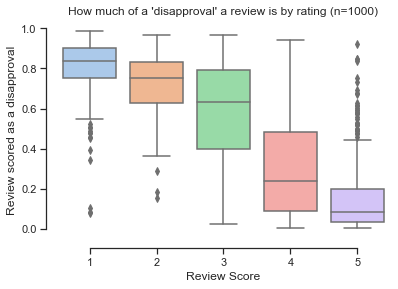

In [67]:
sns.set_theme(style="ticks", palette="pastel")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="overall", y="disapproval per zero shot facebook/bart-large-mnli",
            data=df1000[df1000['endorsement per zero shot facebook/bart-large-mnli']>0]).\
set(title = "How much of a 'disapproval' a review is by rating (n=1000)",
                                        xlabel = 'Review Score', 
                           ylabel = 'Review scored as a disapproval')
sns.despine(offset=10, trim=True)

It's sensible that scores of 1 would be more likely to be scored a "disapproval" while scores of 5 would have a lower score on that word.

## Named Entity Recognition
https://huggingface.co/dslim/bert-base-NER?text=My+name+is+Wolfgang+and+I+live+in+Berlin

In [68]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER") 
currentClassifierType = "dslim/bert-base-NER"

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin"

ner_results = nlp(example)
print(ner_results)

[{'entity': 'B-PER', 'score': 0.9990139, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'B-LOC', 'score': 0.999645, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]


In [69]:
#Types of named entites: 
#O 	Outside of a named entity
#B-MIS 	Beginning of a miscellaneous entity right after another miscellaneous entity
#I-MIS 	Miscellaneous entity
#B-PER 	Beginning of a person’s name right after another person’s name
#I-PER 	Person’s name
#B-ORG 	Beginning of an organization right after another organization
#I-ORG 	organization
#B-LOC 	Beginning of a location right after another location
#I-LOC 	Location

In [70]:
if(currentClassifierType) == "dslim/bert-base-NER":
    df25['NER dslim bert-base'] = df25['reviewText'].apply(lambda x: nlp(x))
    df25['Num of Recognized Entites dslim bert-base'] = df25['NER dslim bert-base'].\
    apply(lambda x: len(x))
else:
    print("Wrong classifier.  Expecting \"dslim/bert-base-NER\"  Run notebook in order.")

In [71]:
df25.head(2)

,overall,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,ReviewTime,Year,distilbert-base-uncased sentiment-analysis,positive sentiment-analysis,negative sentiment-analysis,zero shot facebook/bart-large-mnli,endorsement per zero shot facebook/bart-large-mnli,disapproval per zero shot facebook/bart-large-mnli,NER dslim bert-base,Num of Recognized Entites dslim bert-base
319057,1,False,"11 19, 2016",A2WULF7HX5QRW6,{'Style:': ' USB Flash Drive'},fazil,Windows 10 updates all the time! Causing my co...,Garbage!,1479513600,2016-11-19 00:00:00,2016,"[{'label': 'NEGATIVE', 'score': 0.999703466892...",0.0,0.999703,{'sequence': 'Windows 10 updates all the time!...,0.199932,0.800068,"[{'entity': 'B-MISC', 'score': 0.9983368, 'ind...",2
351090,5,True,"12 30, 2015",A2LDZGQKQTBLKE,{'Platform:': ' PC Download'},joe d,I have been using turbo tax from the start way...,Still The Best,1451433600,2015-12-30 00:00:00,2015,"[{'label': 'NEGATIVE', 'score': 0.993547618389...",0.0,0.993548,{'sequence': 'I have been using turbo tax from...,0.847972,0.152028,"[{'entity': 'B-ORG', 'score': 0.9976609, 'inde...",3


In [72]:
if (not(df1000ReadIn)):
    print("This will take a while...")
    df1000['NER dslim bert-base'] = df1000['reviewText'].apply(lambda x: nlp(x))
    df1000['Num of Recognized Entites dslim bert-base'] = df1000['NER dslim bert-base'].apply(lambda x: len(x))
else:
    print('df1000 read in from file earlier.')

df1000 read in from file earlier.


In [73]:
df1000.head(2)

,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,...,ReviewTime,Year,zero shot facebook/bart-large-mnli,endorsement per zero shot facebook/bart-large-mnli,disapproval per zero shot facebook/bart-large-mnli,NER dslim bert-base,Num of Recognized Entites dslim bert-base,distilbert-base-uncased sentiment-analysis,positive sentiment-analysis,negative sentiment-analysis
0,319057,1,False,"11 19, 2016",A2WULF7HX5QRW6,B01019T6O0,{'Style:': ' USB Flash Drive'},fazil,Windows 10 updates all the time! Causing my co...,Garbage!,...,2016-11-19 00:00:00,2016,{'sequence': 'Windows 10 updates all the time!...,0.199932,0.800068,"[{'entity': 'B-MISC', 'score': 0.9983368, 'ind...",2,"[{'label': 'NEGATIVE', 'score': 0.999703466892...",0.0,0.999703
1,351090,5,True,"12 30, 2015",A2LDZGQKQTBLKE,B01637REAM,{'Platform:': ' PC Download'},joe d,I have been using turbo tax from the start way...,Still The Best,...,2015-12-30 00:00:00,2015,{'sequence': 'I have been using turbo tax from...,0.847972,0.152028,"[{'entity': 'B-ORG', 'score': 0.9976609, 'inde...",3,"[{'label': 'NEGATIVE', 'score': 0.993547618389...",0.0,0.993548


In [74]:
#df1000.to_csv('df1000.csv')

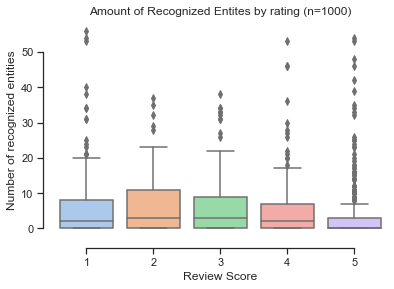

In [75]:
sns.set_theme(style="ticks", palette="pastel")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="overall", y="Num of Recognized Entites dslim bert-base",
            data=df1000[df1000['Num of Recognized Entites dslim bert-base']>=0]).\
set(title = "Amount of Recognized Entites by rating (n=1000)",
                                        xlabel = 'Review Score', 
                           ylabel = 'Number of recognized entities')
sns.despine(offset=10, trim=True)

There doesn't appear to be a relationship between the numbner of recognized entities and the review score.

### Findings / Conclusion: 

As would be predicatable, we showed that higher rated reviews are percieved  more positively by a sentiment analysis transofrmer model, and likewise lower-rated reviews are percieved more negatively by the same algorithm.  
Using a different but similar transformer model, we should that higher rated reviews are more likely to be interprted as an <i>"endorsement"</i> by an alogrithm, where as negative reviews are more likely to be interprted as a <i>"disapproval"</i>.
Lastly, using a "Named Entity Recognition" model (NRE), we did not find a relationship between the amount of recognizable enties and the score of the review.  This final graph could be compared the the length of the review graph earlier in the notebook and it's possibly not suprising that no such relationship was evident.